In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from sklearn.linear_model import LinearRegression
from sklearn import datasets

In [11]:
import math

def convert_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def mask_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    whiteYellowImage = cv2.bitwise_and(image, image, mask = mask)
    return whiteYellowImage

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #print(img.shape)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def cannyimg(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    
    linesFiltered = []
    cumLengthLeft = 0
    a_left = 0
    b_left = 0          
    cumLengthRight = 0
    a_right = 0
    b_right = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:		
            a = float((y2-y1)/(x2-x1))   		
	   
            if not np.isnan(a) or np.isinf(a) or (a == 0):
                if (a > -1.5) and (a < -0.3) :
                    linesFiltered.append(line) 	
                if (a > 0.3) and (a < 1.5) :
                    linesFiltered.append(line)
                
    for line in linesFiltered:
        for x1,y1,x2,y2 in line:
            a = float((y2-y1)/(x2-x1))                         # a : 斜率
            b = (y1-a*x1)                                      # b : 截距
            length = math.sqrt(pow(y2-y1,2)+ pow(x2-x1,2))
	   
            if not np.isnan(a) or np.isinf(a) or (a == 0):
                if (a > -1.5) and (a < -0.3) :
                    cumLengthLeft += pow(length,2)
                    a_left += a * pow(length,2)
                    b_left += b * pow(length,2)

                if (a > 0.3) and (a < 1.5) :               
                    cumLengthRight += pow(length,2)
                    a_right += a * pow(length,2)
                    b_right += b * pow(length,2)
                   

    if (cumLengthLeft != 0) :                     
        a_left /= cumLengthLeft    
        b_left /= cumLengthLeft    
 
    if (cumLengthRight != 0)  :
        a_right /= cumLengthRight
        b_right /= cumLengthRight
        
    y_max = img.shape[0]
    y_min = y_max*0.6
    #print(y_min)
        
    if (a_left!=0):    
        x1_left = int((y_max-b_left)/a_left)
        x2_left = int((y_min-b_left)/a_left)
        #cv2.line(img, (x1_left, y_max), (x2_left, int(y_min)), color, thickness)
    
    if (a_right!=0): 
        x1_right = int((y_max-b_right)/a_right)
        x2_right = int((y_min-b_right)/a_right)
        #cv2.line(img, (x1_right, y_max), (x2_right, int(y_min)), color, thickness)
    
    #print((x1_left, y_max),(x2_left, y_min),(x1_right, y_max), (x2_right, y_min))
    
    cv2.line(img, (x1_left, y_max), (x2_left, int(y_min)), color, thickness)
    cv2.line(img, (x1_right, y_max), (x2_right, int(y_min)), color, thickness)
                    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines2(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    
    return cv2.addWeighted(initial_img, α, img, β, γ)

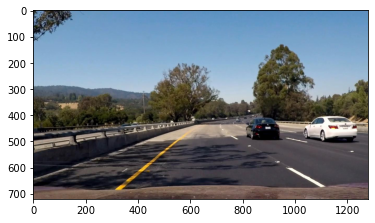

In [17]:
# image = mpimg.imread('test_images/3.8.jpg')
image = mpimg.imread('test_images/3.8.jpg')
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hsl = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plt.imshow(image)

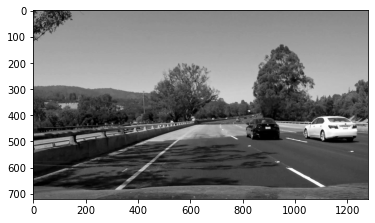

In [18]:
# whiteYellowImage = mask_white_yellow(image)
# gray = grayscale(whiteYellowImage)
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

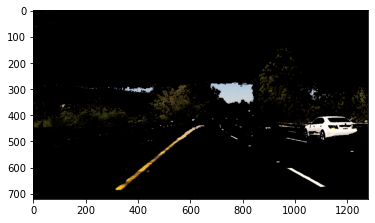

In [21]:
# HSL MASK
# white color mask
lower = np.uint8([  0, 200,   0])
upper = np.uint8([255, 255, 255])
white_mask = cv2.inRange(hsl, lower, upper)
# yellow color mask
lower = np.uint8([ 10,   0, 100])
upper = np.uint8([ 40, 255, 255])
yellow_mask = cv2.inRange(hsl, lower, upper)
# combine the mask
mask = cv2.bitwise_or(white_mask, yellow_mask)
wy_hsl = cv2.bitwise_and(image, image, mask = mask)
plt.imshow(wy_hsl)

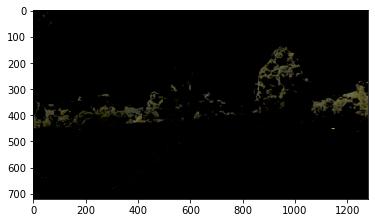

In [20]:
# HSV MASK
# white color mask
lower = np.uint8([  0,   0, 221])
upper = np.uint8([180,  30, 255])
white_mask = cv2.inRange(hsl, lower, upper)
# yellow color mask
lower = np.uint8([ 26,  43,  46])
upper = np.uint8([ 34, 255, 255])
yellow_mask = cv2.inRange(hsv, lower, upper)
# combine the mask
mask = cv2.bitwise_or(white_mask, yellow_mask)
wy_hsv = cv2.bitwise_and(image, image, mask = mask)
plt.imshow(wy_hsv)

In [6]:
X,Y = datasets.make_regression(n_samples=200,n_features=1,n_targets=1,noise=10)
#plt.scatter(X,Y,linewidths=0.1)
print(len(X),len(Y))


200 200


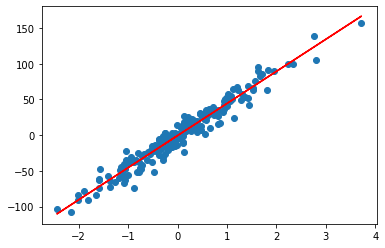

In [7]:
model = LinearRegression()
model.fit(X,Y)
predict = model.predict(X[:200,:])
plt.plot(X,predict,c="red")
plt.scatter(X,Y)

image.shape[0] :  720
image.shape[1] :  1280


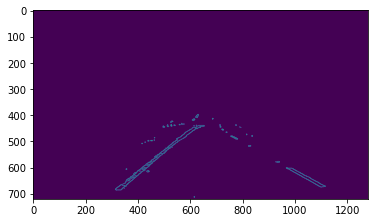

In [12]:

whiteYellowImage = mask_white_yellow(image)
gray = grayscale(whiteYellowImage)

blur = gaussian_blur(gray,5)

canny_img = cannyimg(blur,40,80)

print("image.shape[0] : ",image.shape[0])
print("image.shape[1] : ",image.shape[1])

heigh = image.shape[0]
weigh = image.shape[1]

yTopMask = heigh*0.55
vertices = np.array([[0, heigh], [weigh*0.45, yTopMask], 
				     [weigh*0.55, yTopMask], [weigh,heigh]], np.int32)

masked_image = region_of_interest(canny_img,[vertices])
plt.imshow(masked_image)
# then save them to the test_images_output directory.

In [9]:
#mode2 = LinearRegression()
#mode2.fit([[1,1],[2,2]])
#pred = mode2.predict(X[:200,:])
#plt.plot(X,pred,c="red")
#plt.scatter([1,2,3],[4,5,6])

x=[]
y=[]

for i in range(0,720,1):
    for j in range(0,1280,1):
            if masked_image[i,j] > 0 :
                y.append(i)
                x.append(j)
                #print("(",i,j,")")
                

In [10]:
xp = np.array(x)
yp = np.array(y)

#print(xp.shape)
#print(yp.shape)

xp = xp.reshape(-1,1)
yp = yp.reshape(-1,1)

Interception :  [540.3666117]
Coeficient :  [[0.02459681]]
(xm, ym) =  (540, 0)
(xM, yM) =  (558, 720)


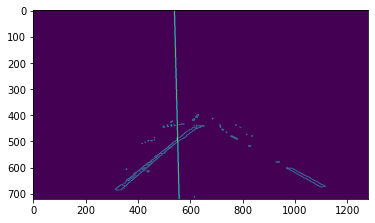

In [11]:
mode2 = LinearRegression()
mode2.fit(xp,yp)

## 計算出截距值與係數值
w_0 = mode2.intercept_
w_1 = mode2.coef_

print("Interception : ", w_0)
print("Coeficient : ", w_1)

ym = 0
xm = int(w_1 * ym +w_0)

yM = 720
xM = int(w_1 * yM +w_0)

print("(xm, ym) = ", (xm, ym))
print("(xM, yM) = ", (xM, yM))

cv2.line(masked_image, (xm, ym), (xM, yM), [255 ,0 ,0], 2)
plt.imshow(masked_image)

xn = np.arange(0,1280,1)
xn = xn.reshape(-1,1)

pred = mode2.predict(xn)
#plt.plot(xn,pred,c="red")
#print(len(x),len(y))
#plt.scatter(xp,yp)
#print(pred.shape)

In [54]:
def draw_lines2(img, lines, color=[255, 0, 0], thickness=5):
    
    leftlinesFiltered = []
    rightlinesFiltered = []

    leftx = []
    lefty = []
    rightx = []
    righty = []

    cumLengthLeft = 0
    a_left = 0
    b_left = 0          
    cumLengthRight = 0
    a_right = 0
    b_right = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:		
            a = float((y2-y1)/(x2-x1))   		
	   
            if not np.isnan(a) or np.isinf(a) or (a == 0):
                if (a > -1.5) and (a < -0.3) :
                    rightlinesFiltered.append(line) 	
                if (a > 0.3) and (a < 1.5) :
                    leftlinesFiltered.append(line)
                
    for line in leftlinesFiltered:
        for x1,y1,x2,y2 in line:
                leftx.append(x1)
                leftx.append(x2)
                lefty.append(y1)
                lefty.append(y2)
            

    for line in rightlinesFiltered:
        for x1,y1,x2,y2 in line:
                rightx.append(x1)
                rightx.append(x2)
                righty.append(y1)
                righty.append(y2)
            

    leftxp = np.array(leftx)
    leftyp = np.array(lefty)
    rightxp = np.array(rightx)
    rightyp = np.array(righty)

    leftxp = leftxp.reshape(-1,1)
    leftyp = leftyp.reshape(-1,1)
    rightxp = rightxp.reshape(-1,1)
    rightyp = rightyp.reshape(-1,1)
	   
    modeleft = LinearRegression()
    modeleft.fit(leftxp,leftyp)

    moderight = LinearRegression()
    moderight.fit(rightxp,rightyp)

    w_0l = modeleft.intercept_
    w_1l = modeleft.coef_

    w_0r = moderight.intercept_
    w_1r = moderight.coef_

    coe = 0.65

    yml = int(img.shape[0] * coe)
    xml = int((yml - w_0l)/w_1l)

    yMl = img.shape[0]
    xMl = int((yMl - w_0l)/w_1l)

    ymr = int(img.shape[0] * coe)
    xmr = int((ymr - w_0r)/w_1r)

    yMr = img.shape[0]
    xMr = int((yMr - w_0r)/w_1r)
                   

    
    cv2.line(img, (xMl, yMl), (xml, yml), color, thickness)
    cv2.line(img, (xMr, yMr), (xmr, ymr), color, thickness)

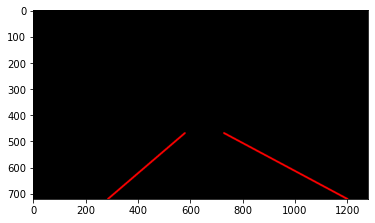

In [55]:
line_img = hough_lines(masked_image, 2, np.pi/180, 15, 15 ,5)
plt.imshow(line_img)

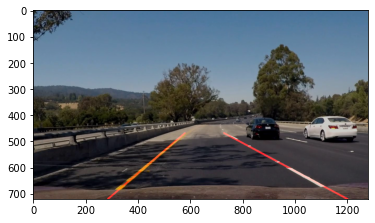

In [56]:
weighted = weighted_img(line_img, image, α=0.8, β=1., γ=0.)
plt.imshow(weighted)